# Crashing with disorder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import numpy as np
import os
from scipy.linalg import orth

from pyTen.decompositions import get_HOSvec, hosvd, als3herm, als4herm2, als

from pyFisher.fisher_functions import get_W3, get_W4, normalizevecs,\
    getOutputFields,  fisher, get_oopms, get_fish_oopms
from pyFisher.optimize_fisher import optimize_inputNopms

from functions import colorize, rnd_cpx_disk, norm_inner, cpx_corr

In [3]:
# Define default plotting options
%matplotlib inline

zf = 1 # zoom factor
lw = zf*2 # line width 
ms = zf*4 # marker size

SMALL_SIZE = 7*zf
MEDIUM_SIZE = 8*zf
BIGGER_SIZE = 9*zf

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
plt.rc('figure', facecolor='white') # white background for VSC

cmap_int = 'gray'
cmap_fish = 'inferno'
cmisv = matplotlib.cm.get_cmap('Oranges')
cmrnd = matplotlib.cm.get_cmap('Purples')
cmmod = matplotlib.cm.get_cmap('Blues')
cmmiic = matplotlib.cm.get_cmap('Reds')
crnd = cmrnd(1.)
cmod = cmmod(0.8)
cisv = cmisv(0.7)
cmiic = cmmiic(0.8)

fig_path = os.path.abspath(os.path.join('Figures','Main'))

# 1. Load data and parameter definition

In [4]:
data_path = os.path.abspath('Data')

# Load TMs for mode computation
TMs4modes = np.load(os.path.join(data_path,'TMs4modes.npy'))
dz4modes = 2 # um
# Load TMs and deformations values for larger deformations
TMs_large_def = np.load(os.path.join(data_path,'TMs_large_def.npy'))
dz_large_def = np.load(os.path.join(data_path,'dz_large_def.npy'))

# Define number of output modes and modes of the fiber
N_out = int(np.shape(TMs4modes)[-2]**(1/2))
n_mod = np.shape(TMs4modes)[-1]

# To plot output fields
def plot_field(field, ax=None, cpx=False, **kwargs):
    sh = (N_out,N_out)
    if cpx:
        field2p = colorize(np.reshape(field, sh))
    else :
        field2p = np.reshape(field, sh)
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    return ax.imshow(field2p, **kwargs)

# 2. Optimizing the input field for pixels as output modes

## 2.1. Finding the optimal crashing channel

First we need to define the tensor

In [12]:
W3 = get_W3(TMs4modes)

Compute the HOSVD and identify the third-order ISVs

In [13]:
Xisv = get_HOSvec(W3, 2).T
Fisv = fisher(Xisv, TMs4modes)

Compute the optimal crashing channel with the ALS algorithm

If symmetry is preserved then it needs to be equal to 1: 0.9997318


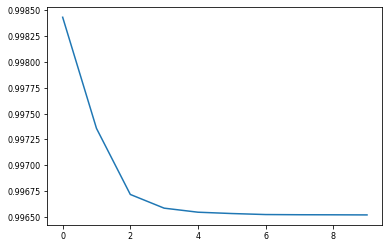

In [9]:
# the first element of init_fact_mat just needs to be the right shape but its values
# are never used in the computation
seed_w3 = [np.empty((W3.shape[0],1), dtype=np.csingle),Xisv[0,:,None].conj(),Xisv[0,:,None]]
fact_mat, cost_evol = als(W3, 1, 10, init_fact_mat=seed_w3, evol=True)
plt.plot(cost_evol)
print('If symmetry is preserved then it needs to be equal to 1:', 
      np.abs(norm_inner(fact_mat[1][:,0].conj(),fact_mat[2][:,0])))
Xmiic = fact_mat[2][:,0]
Fmiic = fisher(Xmiic, TMs4modes)

If the result does not satisfy the partial symmetries of the original tensor then we can use the symmetrized version 

If symmetry is preserved then it needs to be equal to 1: (1+0j)


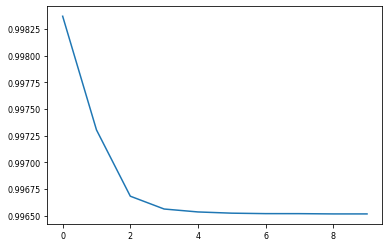

In [12]:
fact_mat, cost_evol = als3herm(W3, 1, 10, init_fact_mat=seed_w3, evol=True)
plt.plot(cost_evol)
print('If symmetry is preserved then it needs to be equal to 1:', 
      norm_inner(fact_mat[1][:,0].conj(),fact_mat[2][:,0]))
Xmiic = fact_mat[2][:,0]
Fmiic = fisher(Xmiic, TMs4modes)

## 2.2. Comparing Fisher information values

Define random inputs and fiber modes, and compute their Fisher information 

In [21]:
n_rnd = 1000
Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Frnd = fisher(Xrnd, TMs4modes[:2])

Xmod = np.eye(n_mod, dtype=complex)[:n_mod]
Fmod = fisher(Xmod, TMs4modes[:2])

Given that the units of the Fisher information are arbitrary, we can normalize them with respect to the mean of the random inputs to simply the comparison

In [22]:
Fnorm_fac = np.mean(Frnd)
Frnd /= Fnorm_fac
Fmod /= Fnorm_fac
Fisv /= Fnorm_fac
Fmiic /= Fnorm_fac

Plot the results

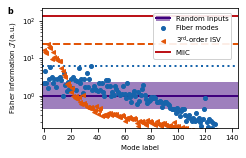

In [47]:
fig, ax = plt.subplots(1,1, figsize=(zf*3.5,zf*2.2))

# Random
ln1p = ax.fill_between(np.arange(-1,n_mod+1),np.max(Frnd), np.min(Frnd),
    facecolor=crnd,alpha=0.5, lw=lw)
ln1 = ax.axhline(np.mean(Frnd), linestyle='-', c=crnd, lw=lw)
# Fiber modes
ln2, = ax.plot(np.arange(n_mod),   Fmod,'o', markersize=ms, c=cmod)
ax.axhline(np.max(Fmod), linestyle=':', c=cmod, lw=lw)
# third-order ISV
ln3, = ax.plot(np.arange(n_mod), Fisv[:n_mod], '<', markersize=ms, c=cisv)
ax.axhline(np.max(Fisv), linestyle='--', c=cisv, lw=lw)
# MIIC
ln4 = ax.axhline(Fmiic, c=cmiic, lw=lw)

lns = [(ln1,ln1p),ln2,ln3,ln4]
lgd =ax.legend(lns,['Random inputs','Fiber modes',
    '3${}^\mathregular{rd}$-order ISV','MIIC'], bbox_to_anchor=(.55,.55),
    facecolor='white',framealpha=0.9)
ax.set_xlabel('Mode label')
ax.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax.set_yscale('log')
ax.set_ylim(Fmiic *1e-3)
ax.set_xlim(-1.,n_mod)

ax.text(-0.18,0.95, 'b', transform=ax.transAxes,  fontweight='bold')

plt.savefig(os.path.join(fig_path,'fish_pix.pdf'),bbox_inches='tight')

## 2.3. Behavior for large deformations

First we compute the change in intensity over large deformations and plot it

In [27]:
def get_IchgVSdx(Xs, TMs, TMref):
    Ydx = getOutputFields(Xs,TMs)
    Yref = getOutputFields(Xs,TMref)
    Ydx = np.abs(Ydx)**2
    Yref = np.abs(Yref)**2
    chg = np.sum((Yref-Ydx)**2, axis=-1)
    return chg

In [28]:
chg_mod = get_IchgVSdx(Xmod, TMs_large_def, TMs4modes[1])
chg_isv = get_IchgVSdx(Xisv, TMs_large_def, TMs4modes[1])
chg_rnd = get_IchgVSdx(Xrnd, TMs_large_def, TMs4modes[1])
chg_miic = get_IchgVSdx(Xmiic, TMs_large_def, TMs4modes[1])

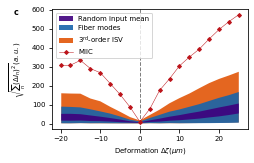

In [46]:
plt.figure(figsize = (zf*3.5,zf*2.2))

dxp = dz_large_def 
fun_scale = lambda x : x**(1/2) 

# Reference deformation
plt.gca().axvline(0, c='gray', linestyle = 'dashed', lw=lw/2)
# third-order ISV
ln3 = plt.fill_between(dxp, fun_scale(np.max(chg_isv, axis=1)), 
                        fun_scale(np.min(chg_isv, axis=1)), 
                        facecolor=cisv, alpha=.9)
# fiber modes
ln2 = plt.fill_between(dxp, fun_scale(np.max(chg_mod, axis=1)), 
                        fun_scale(np.min(chg_mod, axis=1)), 
                        facecolor=cmod, alpha=.9)
# random inputs
ln1 = plt.fill_between(dxp, fun_scale(np.max(chg_rnd, axis=1)), 
                        fun_scale(np.min(chg_rnd, axis=1)), 
                        facecolor=crnd, alpha=.9)
# MIIC
ln4, = plt.plot(dxp, fun_scale(chg_miic), lw=lw/4, 
                c=cmiic, markersize=0.7*ms, marker='D')

ax.set_ylim(-0.5,600)
ax.set_xlim(dxp[0],dxp[-1])

plt.legend([ln1,ln2,ln3,ln4], ['Random inputs','Fiber modes',
    '3${}^\mathregular{rd}$-order ISV','MIIC'], loc='upper left')
plt.xlabel('Deformation $\Delta \zeta (\mu m)$')
plt.ylabel('$\sqrt{\sum_n (\Delta I_n)^2}  (a.u.)$ ')

plt.gca().text(-0.2,0.95, 'c', transform=plt.gca().transAxes,  fontweight='bold')

plt.savefig(os.path.join(fig_path,'Ichg_vs_def.pdf'),bbox_inches='tight')

Then we can compare the intensity distributions 

In [5]:
X4est = np.load(os.path.join(data_path,'Xestimate.npy'))
TMs4fieldplot = np.array([TMs4modes[1], TMs_large_def[-1]])
Yints4p = np.abs(getOutputFields(X4est[::-1], TMs4fieldplot))**2
Yints4p /= np.max(Yints4p)

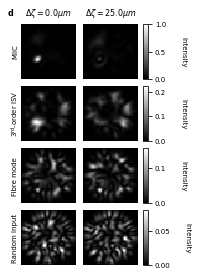

In [53]:
fig = plt.figure(figsize=(zf*5,zf*8))
titles = ['Random input', 'Fibre mode', '3${}^\mathregular{rd}$-order ISV', 'MIIC']

grid = AxesGrid(fig, 122,  
                nrows_ncols=(4, 2),
                axes_pad=0.10,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="edge",
                cbar_size="8%",
                cbar_pad="10%",
                )

for i in range(4):
    curr_max = np.max(Yints4p[:,i])
    for j in range(2):
        ig = 2*i +j
        
        im = plot_field(Yints4p[j,i],grid[ig],vmin=0,vmax=curr_max,cmap=cmap_int,
                            interpolation='none')
        if j<1:
            grid[ig].text(-0.1,0.5, titles[-1-i], transform=grid[ig].transAxes, 
                          horizontalalignment='center', verticalalignment='center', 
                          fontsize=SMALL_SIZE, rotation=90)
        if j==1:
            cb = grid.cbar_axes[i].colorbar(im)
            cb.set_label('Intensity', rotation=270)
            grid.cbar_axes[i].yaxis.labelpad = 20
        grid[ig].tick_params(left=False, right=False, labelleft=False,
                             labelbottom=False, bottom=False)
for cax in grid.cbar_axes:
    cax.toggle_label(True)
grid[1].text(0.5,1.2, '$\Delta \zeta =$'+str(np.round(dxp[-1],0))+'$\mu m$',
             transform = grid[1].transAxes, horizontalalignment='center',
             verticalalignment='center',fontsize=MEDIUM_SIZE)
grid[0].text(0.5,1.2, '$\Delta \zeta = 0.0 \mu m$', transform=grid[0].transAxes, 
             horizontalalignment='center', verticalalignment='center', fontsize=MEDIUM_SIZE)

grid[0].text(-0.25,1.15, 'd', transform=grid[0].transAxes,  fontweight='bold')

plt.savefig(os.path.join(fig_path,'fields_vs_def.pdf'),bbox_inches='tight')

# 3. Estimating deformations

First we load the data for he estimation

In [54]:
int_sc = (0.2/0.45)**2
dz4der = 3.00264
I4der = np.load(os.path.join(data_path,'I4der.npy'))
I4ref = np.load(os.path.join(data_path,'I4ref.npy'))
I4est = np.load(os.path.join(data_path,'I4est.npy'))
dz4est = np.load(os.path.join(data_path,'dz4est.npy'))

Then we define function for plotting the Fisher informaiton and estimating the deformation

In [55]:
# For plotting the FIsher information
def plot_fish(fish, ax, **kwargs):
    sh = (N_out,N_out)
    field2p = np.reshape(fish, sh)
    ax.axis('off')
    return ax.matshow(field2p, **kwargs)

# Function for computing the estimation
def estimate_def(Imeas, Iref0, Ider):
    return np.sum(Ider * (Imeas - Iref0), axis=-1)/np.sum(Ider**2, axis=-1)

We compute the estimations and the derivatives

In [56]:
Iders = int_sc * np.mean(I4der[1]-I4der[0], axis=0)/dz4der
Irefs = np.mean(I4ref, axis=0)

def_estimates = estimate_def(I4est, Irefs, Iders)
std_def = np.mean(np.std(def_estimates, axis=1),axis=0)

And plot the results

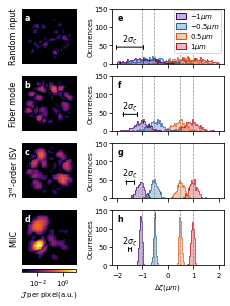

In [83]:
fig, axs = plt.subplots(4,2,figsize=(zf*3.2,zf*4.))
labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'MIIC']
nb_lb = [['a','b','c','d'],['e','f','g','h']]
alpha = 0.3
# define colors for histograms
chist = [crnd, cmod, cisv, cmiic]
cf = []
for i in range(len(chist)):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),alpha)]

# Define scaling for Fisher plots
sca_fac = 1/np.sum(np.abs(Iders[0])**2)
fmax = sca_fac * np.max((np.abs(Iders)**2).ravel())
fmin = 0.5*fmax*(10**(-4))
# remove zero values to plot in log scale
Iders[np.abs(Iders)==0] = fmin*(10**(-4))

# ranges for histograms
y_lim = 150
xmin = np.round(dz4est[0])-1
xmax = np.round(dz4est[-1])+1
bins = np.linspace(xmin,xmax,120)
# arrow style and pos for std_def
y_arrow = y_lim*0.3
x_arrow = -1.5#target_def_list[-1]
style = ArrowStyle('|-|',widthA=2.0*zf,widthB=2.0*zf)#, head_length=4, head_width=1.5)
    
for ip in range(4):
    #Fisher plots
    pl_fish = plot_fish(sca_fac*(np.abs(Iders[ip])**2), axs[ip,0],
                        norm=colors.LogNorm(vmin=fmin, vmax=fmax),
                        cmap=cmap_fish,
                        interpolation='none')
    axs[ip,0].axis('off')
    axs[ip,0].set_ylabel(labels[ip])
    axs[ip,0].text(-0.15,0.5, labels[ip],transform = axs[ip,0].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=90)

    if ip<3:
        axs[ip,1].axes.xaxis.set_ticklabels([])

    axs[ip,1].set_ylim(0,y_lim)
    
    axs[3,1].set_xlabel('$\Delta \zeta (\mu m)$')
    xvar = def_estimates[:,:,ip].T
    axs[ip,1].hist(xvar, bins, color=chist, histtype='step', lw=lw/3)
    axs[ip,1].hist(xvar, bins, color=chist, alpha=alpha, histtype='stepfilled')

    for n in range(len(dz4est)):
        axs[ip,1].axvline(x=dz4est[n], c='gray',linewidth=lw/3, ls='--')

    std_arrow = FancyArrowPatch((x_arrow-std_def[ip],y_arrow),
                                (x_arrow+std_def[ip],y_arrow),
                                shrinkA = 0, shrinkB = 0, color='black', lw=lw/2,
                                arrowstyle=style)
    axs[ip,1].add_patch(std_arrow)
    axs[ip,1].text(x_arrow,y_arrow+0.1*y_lim, r'$2\sigma_\zeta$', 
                   fontweight='bold', horizontalalignment='center')

    # axs[ip,1].set_box_aspect(1/2.4)
    axs[ip,1].set_xticks(np.arange(xmin,xmax+1,1))
    axs[ip,1].set_ylabel('Ocurrences')
    axs[ip,0].text(0.05,0.8,nb_lb[0][ip], transform=axs[ip,0].transAxes, 
                   color='w', fontweight='bold')
    axs[ip,1].text(0.05,0.8,nb_lb[1][ip], transform=axs[ip,1].transAxes, 
                   color='k', fontweight='bold')
    
    axs[ip,1].get_yaxis().labelpad = -0.
    axs[ip,1].yaxis.set_tick_params(pad=1)

handles = [matplotlib.patches.Rectangle((0,0),.01,.01,color=cf[i],ec=chist[i]) for i in range(4)]
labels= ["$-1\mu m$","$-0.5\mu m$", "$0.5\mu m$",'$1\mu m$']
fig.legend(handles, labels, fontsize=SMALL_SIZE, ncol=1, loc=(0.755,0.825), 
           frameon=True, handleheight=.8, handlelength=1.5, labelspacing=0., 
           columnspacing=0.2, handletextpad=0.5, borderpad=0.2)

fig.tight_layout(pad=0., w_pad=0., h_pad=0.8)

cb_width =0.235
cb_height = 0.01
cbar_ax2 = fig.add_axes([0.125, 0.07, cb_width, cb_height])
cbar2=fig.colorbar(pl_fish, cax=cbar_ax2, orientation='horizontal', 
                   label='$\mathcal{J}$ per pixel(a.u.)',
                   ticks=[1e-2,1e0])
cbar_ax2.xaxis.set_ticks_position('bottom')
cbar_ax2.get_xaxis().labelpad = 0
cbar_ax2.xaxis.set_tick_params(pad=2)

plt.savefig(os.path.join(fig_path,'Est_def.pdf'), bbox_inches='tight')

# 4. Reaching the precision limit

## 4.1. Computation of optimal fields

First we change the output basis into a smaller basis that still capture all the information. This basis is constructed from the output singular vector for the two matrices used to compute the higher-order tensors:

In [5]:
vecs_new_basis = np.zeros((N_out**2,n_mod*2), dtype=complex)
for i, tm in enumerate(TMs4modes):
    udef, sdef, vhdef = np.linalg.svd(tm)
    vecs_new_basis[:,n_mod*i:n_mod*(i+1)] = udef[:,:n_mod]

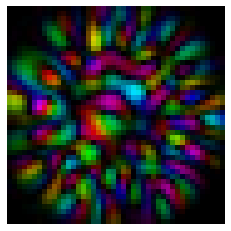

In [6]:
u_nb = orth(vecs_new_basis)
plot_field(u_nb[:,n_mod-1], cpx=True)
TMs_nb= (u_nb[:,:n_mod].T.conj() @ TMs4modes).astype(np.csingle)

We compute the Fisher information for the random wavefronts and the fiber modes when measuring the optimal output projection modes for each output field

In [86]:
Foopm_rnd = get_fish_oopms(Xrnd, TMs_nb)
Foopm_mod = get_fish_oopms(Xmod, TMs_nb)

We compute the fourth-order ISVs 

In [7]:
W4 = get_W4(TMs_nb.astype(np.csingle))
uw4s, sw4 = hosvd(W4, dict_hermsym={'1':0, '3':2})
X4th_isv = uw4s[3].T

Foopm_4isv = get_fish_oopms(X4th_isv, TMs_nb)

In [88]:
seed_out, seed_vals = get_oopms(X4th_isv[0] , TMs_nb, all=False)

Find the field giving te precision limit

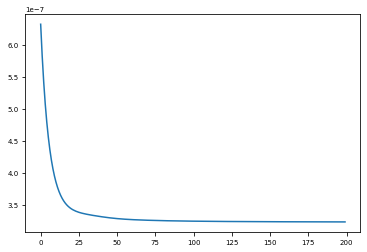

In [8]:
Xlim, evol = optimize_inputNopms(X4th_isv[0], TMs_nb, n_epochs=200,lr=0.3e-2)
Flim = get_fish_oopms(Xlim, TMs_nb)
plt.plot(evol)

Find the best rank-one approximation of W4

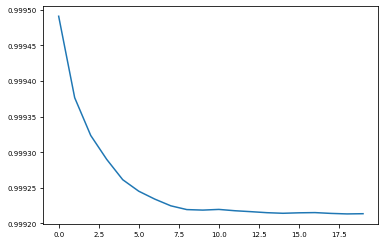

In [9]:
anti_flag = False
if sw4[0,0,0,0] < 0: anti_flag=True
seed_w4 = [uw4s[0][:,0,None],uw4s[1][:,0,None],uw4s[2][:,0,None],uw4s[3][:,0,None]]
fact_mat_w4, cost_evol = als4herm2(W4, 1, 20, 
                          init_fact_mat=seed_w4, 
                          evol=True, anti=anti_flag)
plt.plot(cost_evol)

In [10]:
Xb1opm = fact_mat_w4[3][:,0]
_, vals_b1opm = get_oopms(Xb1opm , TMs_nb, all=False)
Fb1opm = np.max(np.abs(vals_b1opm)**2)

## 4.2. Comparisson of fields using optimal OPMs

Before plotting we normalize the Fisher information with respect to the mean Fisher information for random inputs measured in the pixel basis

In [93]:
Foopm_rnd /= Fnorm_fac
Foopm_mod /= Fnorm_fac
Fb1opm /= Fnorm_fac
Flim /= Fnorm_fac
Foopm_4isv /= Fnorm_fac

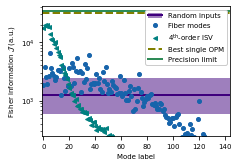

In [99]:
fig, ax1 = plt.subplots(1,1, figsize=(zf*3.2, zf*2.2), layout="constrained")

# Random wavefronts
ln1p = ax1.fill_between(np.arange(-1,n_mod+1),np.max(Foopm_rnd), np.min(Foopm_rnd),
    facecolor=crnd, alpha=0.5)
ln1 = ax1.axhline(np.mean(Foopm_rnd), linestyle='-', c=crnd, lw=lw) 
# Fiber modes
ln2, = ax1.plot(np.arange(n_mod), Foopm_mod,'o',markersize=ms, c=cmod)
# best 1 out
ln3 = ax1.axhline(Fb1opm, c='olive', linestyle='--', lw=lw)
# sing W4
ln5, = ax1.plot(np.arange(n_mod), Foopm_4isv,'<',markersize=ms, c='teal')
# Precision limit
ln6 = ax1.axhline(Flim, c='seagreen',lw=lw)


lns = [(ln1p,ln1),ln2,ln5,ln3,ln6]
lgd =ax1.legend(lns,[
    'Random inputs','Fiber modes',
    '4${}^\mathregular{th}$-order ISV','Best single OPM','Precision limit'],
    loc=0, facecolor='white',framealpha=1)
    
ax1.set_xlabel('Mode label')
ax1.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax1.set_yscale('log')
ax1.set_xlim(-1.,n_mod-0.)
ax1.set_ylim(2.5e2,Flim*1.2)


plt.savefig(os.path.join(fig_path,'Precision_lim.pdf'),bbox_inches='tight')

## 4.3. Comparisson of fields close to the precision limit

First we compute the output fields

In [14]:
Xbest_list = [Xlim, X4th_isv[0], Xb1opm, Xisv[0]]
Ybest_list = getOutputFields(np.array(Xbest_list ), TMs4modes[1])
Ybest_list /= np.max(np.abs(Ybest_list))

We plot them and compute the correlation with the one reacihng the precision limit

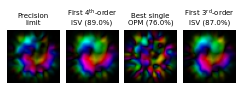

In [15]:
titles = ['Precision\nlimit', 'First 4${}^\mathregular{th}$-order\nISV', 
    'Best single\nOPM','First 3${}^\mathregular{rd}$-order\nISV']

fig, axs = plt.subplots(1,4,figsize=(zf*3.2,zf*0.3*3.2))

for i, ax in enumerate(axs.ravel()):
    corr = cpx_corr(Ybest_list[i],Ybest_list[0])
    if i>0:
        ax.set_title(titles[i]+' ('+str(np.round(np.abs(corr)*100,0))+'%)', fontsize=SMALL_SIZE)
    else:
        ax.set_title(titles[i], fontsize=SMALL_SIZE)
    pl_int = plot_field(np.exp(-1j*np.angle(corr))*Ybest_list[i], ax, cpx=True)
    ax.axis('off')

plt.tight_layout(pad=0., w_pad=0.5, h_pad=0.)


plt.savefig(os.path.join(fig_path,'field_cpx_comp.pdf'),bbox_inches='tight',dpi=400)

We also show the intensity distribution

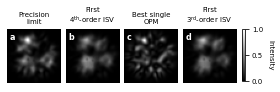

In [123]:
titles = ['Precision\nlimit', 'First\n4${}^\mathregular{th}$-order ISV', 
    'Best single\nOPM','First\n3${}^\mathregular{rd}$-order ISV']
nb_lb = ['a','b','c','d']

fig, axs = plt.subplots(1,4,figsize=(zf*3.2,zf*0.3*3.2))
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i], fontsize=SMALL_SIZE)
    # pl_int = ax.imshow(horz_reshp(Ysbest[i]),cmap=cmap_int, vmin=0,vmax=1)
    pl_int = plot_field(np.abs(Ybest_list[i])**2, ax, cmap=cmap_int, vmin=0,vmax=1)
    ax.axis('off')
    
    ax.text(0.05,0.8,nb_lb[i], transform=ax.transAxes, color='w', fontweight='bold')

plt.tight_layout(pad=0., w_pad=0.5, h_pad=0.)

cb_width =0.015
cb_height = 0.75
cbar_ax2 = fig.add_axes([1.02, 0.02, cb_width, cb_height])
cbar2=fig.colorbar(pl_int, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Intensity', rotation=270, fontsize=SMALL_SIZE)
cbar_ax2.get_yaxis().labelpad = 10

plt.savefig(os.path.join(fig_path,'field_comp.pdf'),bbox_inches='tight',dpi=400)